## computing MLD

- These are the first attemps. Still trying to validate and make sure the calculation is good

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw

from scipy.interpolate import griddata
import matplotlib.colors as mcolors

import scipy.interpolate as spi
import cmocean
import seawater as sw
import matplotlib.dates as mdates

In [2]:
path = "/home/mtorres4/project/MetaRhythms/"

### Load CTD Data

In [3]:
url = "https://datadocs.bco-dmo.org/file/7DkKkrjTW5K4Pw/3918_v8_bats_ctd.csv"
df = pd.read_csv(url)
df.head(5)

,ID,ISO_DateTime_UTC_deployed,ISO_DateTime_UTC_recovered,Vessel,Latitude_deployed,Longitude_deployed,Latitude_recovered,Longitude_recovered,Cruise_type,Cruise_num,...,Flu,QF_Flu,PAR,QF_PAR,Date_deployed,Date_recovered,Time_deployed,Time_recovered,Decimal_Year_deployed,Decimal_Year_recovered
0,10001001,1988-10-20T22:30:00Z,1988-10-21T02:00:00Z,R/V Weatherbird II,31.783,-64.116,NaN,NaN,BATS Core,10001,...,NaN,9,NaN,9,19881020,19881021,2230,200.0,1988.803108,1988.803506
1,10001001,1988-10-20T22:30:00Z,1988-10-21T02:00:00Z,R/V Weatherbird II,31.783,-64.116,NaN,NaN,BATS Core,10001,...,NaN,9,NaN,9,19881020,19881021,2230,200.0,1988.803108,1988.803506
2,10001001,1988-10-20T22:30:00Z,1988-10-21T02:00:00Z,R/V Weatherbird II,31.783,-64.116,NaN,NaN,BATS Core,10001,...,NaN,9,NaN,9,19881020,19881021,2230,200.0,1988.803108,1988.803506
3,10001001,1988-10-20T22:30:00Z,1988-10-21T02:00:00Z,R/V Weatherbird II,31.783,-64.116,NaN,NaN,BATS Core,10001,...,NaN,9,NaN,9,19881020,19881021,2230,200.0,1988.803108,1988.803506
4,10001001,1988-10-20T22:30:00Z,1988-10-21T02:00:00Z,R/V Weatherbird II,31.783,-64.116,NaN,NaN,BATS Core,10001,...,NaN,9,NaN,9,19881020,19881021,2230,200.0,1988.803108,1988.803506


In [4]:
df = df.drop(
    columns=[
        'ID',
        'ISO_DateTime_UTC_recovered',
        'Vessel',
        'Latitude_recovered', 
        'Longitude_recovered', 
        'Cruise_type', 
        'Cruise_num',
        'Cast',
        'QF_Depth',
        'QF_Pressure',
        'QF_Temperature',
        'QF_Salinity', 
        'Oxygen',
        'QF_Oxygen', 
        'BAC',
        'QF_BAC',
        'Flu', 
        'QF_Flu', 
        'PAR', 
        'QF_PAR',
        'Date_deployed', 
        'Date_recovered', 
        'Time_deployed',
        'Time_recovered', 
        'Decimal_Year_recovered']
)

In [5]:
df['datetime'] = pd.to_datetime(df['ISO_DateTime_UTC_deployed'], errors="coerce")#.astype('datetime64[s]')

In [6]:
def make_depth_datasets(df, depths, time='datetime'):
    
    da = {}
    for min_depth, max_depth, label in depths:

        df_subset = df[(df['Depth'] >= min_depth) & (df['Depth'] <= max_depth)].copy()
        
        df_subset['YearMonthDay'] = pd.to_datetime(df_subset[time]).dt.floor('D')
        # df_subset['YearMonth'] = df_subset[time].dt.strftime('%Y-%m')
        df_subset['YearMonth'] = df_subset[time].dt.to_period('M')
        df_subset['Month'] = df_subset[time].dt.month
        df_subset['Year'] = df_subset[time].dt.year
        
        da[label] = df_subset
        
    return da

In [7]:
depth_ranges = [
    (0, 3000, 'surf')]
da = make_depth_datasets(df, depth_ranges)

In [8]:
data = da["surf"]

In [9]:
import numpy as np
import pandas as pd
import gsw

def compute_mld_timeseries(
    df,
    threshold=0.125,
    reference_depth=0,
    time_format="%Y-%m-%d",
    smooth_window=None
):
    df["TimeGroup"] = df["YearMonthDay"].dt.strftime(time_format)

    def compute_mld_for_time(group):
        group = group.sort_values("Pressure").copy()

        group["Sigma_theta"] = gsw.density.sigma0(
            group["Salinity"].values, group["Temperature"].values
        )
        if smooth_window is not None and smooth_window > 1:
            group["Sigma_theta_smooth"] = (
                group["Sigma_theta"]
                .rolling(window=smooth_window, min_periods=1)
                .mean()
            )
        else:
            group["Sigma_theta_smooth"] = group["Sigma_theta"]

        if group["Pressure"].min() > reference_depth:
            return np.nan

        surface_density = np.interp(
            reference_depth,
            group["Pressure"],
            group["Sigma_theta_smooth"]
        )

        density_diff = group["Sigma_theta_smooth"] - surface_density

        exceeding = group.loc[density_diff > threshold, "Pressure"]
        if not exceeding.empty:
            return exceeding.min()
        else:
            return np.nan

    mld_series = df.groupby("TimeGroup").apply(compute_mld_for_time)

    return mld_series

In [10]:
mld = compute_mld_timeseries(
    data,
    threshold=0.125,
    reference_depth=20,
    time_format="%Y-%m-%d",
    smooth_window=20
)

In [11]:
mld_sel = mld.loc['2003-01-01':'2005-01-01']

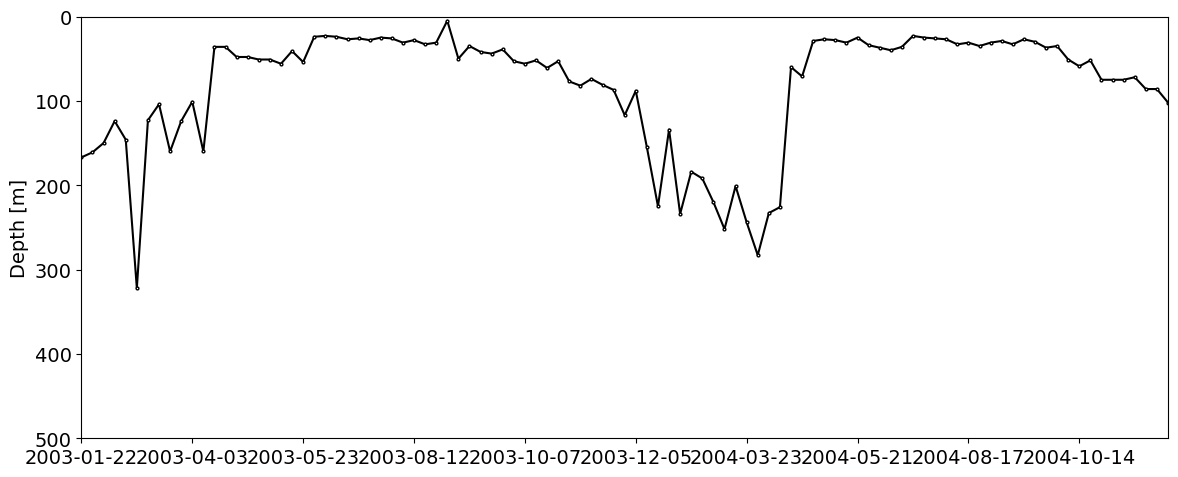

In [17]:
plt.figure(figsize=(12, 5))
plt.rcParams.update({'font.size': 14})
# mld_sel.plot(color='k')
plt.plot(mld_sel, marker='o', linestyle='-', color='k', markerfacecolor='white', markeredgecolor='k', markersize=2)
# plt.xticks(fontsize=1, rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Show only 10 ticks
plt.ylim(500, 0)
plt.ylabel('Depth [m]')
plt.xlim(mld_sel.index[0],mld_sel.index[-1])
# plt.xlabel('Time')
plt.tight_layout()
plt.savefig(f'{path}figures/MLD-timeseries-2003-2005.png', dpi=300)
plt.show()